In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from scipy.linalg import solve_continuous_are
import os
import math
import imageio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from LQR_model import LQRModel

In [2]:
#Get gymnasium version
print(gym.__version__)

0.29.1


# Data Collection
- Run episodes with sampled actions saving each {S,A,S',R} tuple.
- Action sampling is a small inductive bias and a choice.
- Action = continuous (a,b) pair, where a = main thruster and b = side thurster.
- a samples [-1,1], but all values less than 0 are no boost. 
- b samples [-1,1] where values between -0.5 and 0.5 are no boost. Values between -1 and -0.5 are left boost (opposite for right boost)
- This setup includes only actions that cause boost to occur.
## Reward
- This setup overrides the default reward and instead aims to keep the lander continously hovering in place. 

In [3]:
data_path = "lunarlander_custom_reward_trained_dataset.pt"
train_data = torch.load(data_path)

In [4]:
state_dim = 8
train_states = train_data['states'] # list of state tensors
train_states = torch.stack(train_states)  # Convert list of tensors to a single tensor
train_states = train_states.view(-1, state_dim)
train_next_states = train_data['next_states'] # list of next state tensors
train_next_states = torch.stack(train_next_states)  # Convert list of tensors to a single tensor
train_next_states = train_next_states.view(-1, state_dim)
train_actions = train_data['actions'] # list of action tensors
train_actions = torch.stack(train_actions)  # Convert list of tensors to a single tensor
train_actions = train_actions.view(-1, 2)
train_rewards = train_data['rewards'] # list of reward tensors
train_rewards = torch.stack(train_rewards)  # Convert list of tensors to a single tensor
train_rewards = train_rewards.view(-1)

In [5]:
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_states, train_actions, train_next_states, train_rewards.unsqueeze(1)),
    batch_size=128,
    shuffle=True
)

#split data_loader into train and test
train_size = int(0.8 * len(data_loader.dataset))
test_size = len(data_loader.dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data_loader.dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)



In [6]:
hidden_state_dim = 64
hidden_action_dim = 64
model = LQRModel(hidden_state_dim=hidden_state_dim,hidden_action_dim=hidden_action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
with torch.no_grad(): 
    for batch in train_loader:
        states, actions, next_states, rewards = batch
        enc_states = model.state_encoder(states)
        print(enc_states.std(dim=1))
        print(enc_states.std(dim=1).shape)
        break

tensor([0.0936, 0.0866, 0.0872, 0.0876, 0.0865, 0.0930, 0.0863, 0.0887, 0.0943,
        0.0922, 0.0906, 0.0880, 0.0857, 0.0918, 0.0848, 0.0879, 0.0875, 0.0882,
        0.0867, 0.0880, 0.0885, 0.0873, 0.0861, 0.0911, 0.0854, 0.0935, 0.0924,
        0.0908, 0.0864, 0.0866, 0.0909, 0.0922, 0.0860, 0.0864, 0.0877, 0.0841,
        0.0939, 0.0910, 0.0864, 0.0856, 0.0873, 0.0851, 0.0854, 0.0901, 0.0874,
        0.0862, 0.0844, 0.0923, 0.0899, 0.0937, 0.0873, 0.0907, 0.0927, 0.0875,
        0.0903, 0.0904, 0.0862, 0.0859, 0.0869, 0.0917, 0.0838, 0.0878, 0.0863,
        0.0856, 0.0863, 0.0843, 0.0917, 0.0893, 0.0918, 0.0898, 0.0877, 0.0892,
        0.0905, 0.0928, 0.0894, 0.0860, 0.0869, 0.0873, 0.0850, 0.0943, 0.0860,
        0.0927, 0.0886, 0.0923, 0.0900, 0.0909, 0.0892, 0.0925, 0.0816, 0.0906,
        0.0834, 0.0879, 0.0873, 0.0855, 0.0879, 0.0908, 0.0888, 0.0911, 0.0887,
        0.0909, 0.0906, 0.0884, 0.0915, 0.0924, 0.0861, 0.0827, 0.0874, 0.0849,
        0.0903, 0.0929, 0.0894, 0.0890, 

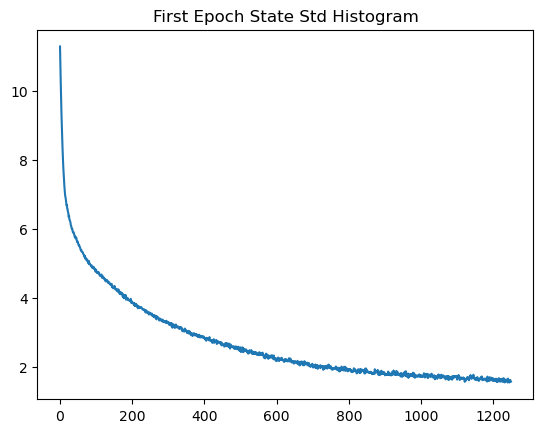

Epoch 0/500, Train State Loss: 0.0002, Train Reward Loss: 0.1342, Train Action Loss: 0.0002, Train State Std: 0.0000
Epoch 0/500, Validation State Loss: 0.0000, Validation Reward Loss: 0.0288, Validation Action Loss: 0.0000 Validation State Std: 0.0123
Epoch 1/500, Train State Loss: 0.0000, Train Reward Loss: 0.0279, Train Action Loss: 0.0000, Train State Std: 0.0000
Epoch 1/500, Validation State Loss: 0.0000, Validation Reward Loss: 0.0274, Validation Action Loss: 0.0000 Validation State Std: 0.0105
Epoch 2/500, Train State Loss: 0.0000, Train Reward Loss: 0.0271, Train Action Loss: 0.0000, Train State Std: 0.0000
Epoch 2/500, Validation State Loss: 0.0000, Validation Reward Loss: 0.0270, Validation Action Loss: 0.0000 Validation State Std: 0.0100
Epoch 3/500, Train State Loss: 0.0000, Train Reward Loss: 0.0267, Train Action Loss: 0.0000, Train State Std: 0.0000
Epoch 3/500, Validation State Loss: 0.0000, Validation Reward Loss: 0.0266, Validation Action Loss: 0.0000 Validation State 

KeyboardInterrupt: 

In [8]:
num_epochs = 500
val_num = len(test_dataset)
criterion = nn.MSELoss()
train_num = len(train_dataset)

# Lists to store losses for plotting
train_total_losses = []
train_state_losses = []
train_reward_losses = []
val_total_losses = []
val_state_losses = []
val_reward_losses = []
train_stds = []
val_stds = []
first_epoch_stds = []
all_train_stds = [] 
all_val_stds = []
all_train_means = []
all_val_means = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_state_loss = 0
    total_reward_loss = 0
    total_action_loss = 0
    total_enc_state_std = 0
    total_std_sum = 0
    total_mean = 0

    for batch in train_loader:
        state_batch, action_batch, next_state_batch, reward_batch = batch

        state_batch = state_batch
        action_batch = action_batch
        

        x_prime_pred, reward_pred = model(state_batch, action_batch)
        decode_x_prime = model.state_decoder(x_prime_pred)

        action_decode_loss = criterion(model.action_decoder(model.action_encoder(action_batch)), action_batch)
        state_loss = criterion(decode_x_prime, next_state_batch)
        reward_loss = criterion(reward_pred, reward_batch.squeeze())
        
        enc_loss = criterion(model.state_encoder(next_state_batch),x_prime_pred)

        state_encoded = model.state_encoder(state_batch)
        with torch.no_grad():
            std_sum = state_encoded.std(dim=1).sum().item()
            total_std_sum += std_sum
            if epoch == 0:
                first_epoch_stds.append(std_sum)
            all_train_stds.append(std_sum)


        auto_encode_loss = criterion(model.state_decoder(state_encoded),state_batch)
        ###Manual Inspect State Decoder
        state_loss = state_loss + enc_loss + auto_encode_loss

        loss = state_loss + reward_loss + action_decode_loss
        #loss = reward_loss + action_decode_loss
        total_loss += loss.item()
        total_action_loss += action_decode_loss.item()
        total_state_loss += state_loss.item()
        total_reward_loss += reward_loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 0:
        #plot first epoch stds as line plot
        plt.plot(first_epoch_stds)
        plt.title("First Epoch State Std Histogram")
        plt.show()


    total_std_sum = total_enc_state_std / train_num
    train_stds.append(total_std_sum)
    total_loss /= train_num
    total_state_loss /= train_num
    total_reward_loss /= train_num
    total_action_loss /= train_num
    train_total_losses.append(total_loss)
    train_state_losses.append(total_state_loss)
    train_reward_losses.append(total_reward_loss)

    print(f"Epoch {epoch}/{num_epochs}, Train State Loss: {total_state_loss:.4f}, Train Reward Loss: {total_reward_loss:.4f}, Train Action Loss: {total_action_loss:.4f}, Train State Std: {total_std_sum:.4f}")

    model.eval()
    val_total_loss = 0
    val_state_loss = 0
    val_reward_loss = 0
    val_action_loss = 0
    val_std_sum = 0
    with torch.no_grad():
        for val_batch in test_loader:
            val_state_batch, val_action_batch, val_next_state_batch, val_reward_batch = val_batch

            val_state_batch = val_state_batch
            val_action_batch = val_action_batch
            #val_state_batch = scale_tensor_up(val_state_batch, scale_factor).unsqueeze(-1)
            #val_action_batch = scale_tensor_up(val_action_batch, scale_factor * 4).unsqueeze(-1)

            val_x_prime_pred, val_reward_pred = model(val_state_batch, val_action_batch)
            #val_x_prime_pred = scale_tensor_down(val_x_prime_pred, scale_factor)
            val_action_loss = criterion(model.action_decoder(model.action_encoder(val_action_batch)), val_action_batch)
            val_decode_x_prime = model.state_decoder(val_x_prime_pred)
            val_state_loss += criterion(val_decode_x_prime, val_next_state_batch).item()
            val_reward_loss += criterion(val_reward_pred, val_reward_batch.squeeze()).item()

            val_enc_loss = criterion(model.state_encoder(val_next_state_batch),val_x_prime_pred)
            val_state_encoded = model.state_encoder(val_state_batch)
            std_sum = val_state_encoded.std(dim=1).sum().item()
            val_std_sum += std_sum
            all_val_stds.append(std_sum)



            val_auto_encode_loss = criterion(model.state_decoder(val_state_encoded),val_state_batch)
            val_state_loss = val_state_loss + val_enc_loss + val_auto_encode_loss


    val_state_loss /= val_num
    val_reward_loss /= val_num
    val_action_loss /= val_num
    val_total_loss = val_state_loss + val_reward_loss
    val_total_losses.append(val_total_loss)
    val_state_losses.append(val_state_loss)
    val_reward_losses.append(val_reward_loss)
    val_stds.append(val_std_sum / val_num)
    val_std_sum = val_std_sum / val_num

    print(f"Epoch {epoch}/{num_epochs}, Validation State Loss: {val_state_loss:.4f}, Validation Reward Loss: {val_reward_loss:.4f}, Validation Action Loss: {val_action_loss:.4f}", f"Validation State Std: {val_std_sum:.4f}")

# Function to plot and save all losses in a single HTML file
def plot_and_save_all_losses(epoch_range, train_losses, val_losses, hidden_dim, filename):
    fig = make_subplots(
        rows=3, cols=1,
        subplot_titles=["Total Loss", "State Loss", "Reward Loss"],
        shared_xaxes=True
    )
    
    # Add traces for Total Loss
    fig.add_trace(go.Scatter(x=epoch_range, y=train_losses[0], mode='lines+markers', name='Train Total Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_range, y=val_losses[0], mode='lines+markers', name='Validation Total Loss'), row=1, col=1)
    
    # Add traces for State Loss
    fig.add_trace(go.Scatter(x=epoch_range, y=train_losses[1], mode='lines+markers', name='Train State Loss'), row=2, col=1)
    fig.add_trace(go.Scatter(x=epoch_range, y=val_losses[1], mode='lines+markers', name='Validation State Loss'), row=2, col=1)
    
    # Add traces for Reward Loss
    fig.add_trace(go.Scatter(x=epoch_range, y=train_losses[2], mode='lines+markers', name='Train Reward Loss'), row=3, col=1)
    fig.add_trace(go.Scatter(x=epoch_range, y=val_losses[2], mode='lines+markers', name='Validation Reward Loss'), row=3, col=1)

    fig.add_trace(go.Scatter(x=epoch_range, y=train_stds, mode='lines+markers', name='Train State Std'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_range, y=val_stds, mode='lines+markers', name='Validation State Std'), row=1, col=1)
    
    # Update layout
    fig.update_layout(
        title=f"Loss Curves (Hidden Dim: {hidden_dim})",
        xaxis_title="Epochs",
        height=900,
        yaxis_title="Loss",
        legend=dict(x=0.1, y=0.9),
    )
    
    # Save as HTML
    os.makedirs("plots", exist_ok=True)
    filepath = f"plots/{filename}.html"
    fig.write_html(filepath)
    print(f"Saved {filepath}")

# Call the function with collected losses
epochs = list(range(num_epochs))
plot_and_save_all_losses(
    epoch_range=epochs,
    train_losses=[train_total_losses, train_state_losses, train_reward_losses],
    val_losses=[val_total_losses, val_state_losses, val_reward_losses],
    hidden_dim=hidden_state_dim,
    filename=f"loss_curves_{hidden_state_dim}"
)


In [9]:
#random state
random_state = train_data['states'][0]
#random enc state
random_enc_state = model.state_encoder(random_state.unsqueeze(0))
for i in range(64):
    print(random_enc_state[0][i])

tensor([-0.0216,  0.0015,  0.0056, -0.0265,  0.0035, -0.0049, -0.0285, -0.0266,
         0.0165, -0.0179,  0.0222, -0.0134, -0.0022,  0.0214, -0.0112,  0.0207,
        -0.0060, -0.0038,  0.0139,  0.0009, -0.0043,  0.0101,  0.0165, -0.0180,
        -0.0082,  0.0038, -0.0047,  0.0053, -0.0092, -0.0196,  0.0199, -0.0008,
        -0.0316,  0.0174, -0.0220,  0.0079, -0.0149, -0.0011,  0.0078, -0.0004,
         0.0161, -0.0149,  0.0285, -0.0188, -0.0071,  0.0039, -0.0084,  0.0137,
         0.0096,  0.0099,  0.0059, -0.0161,  0.0063,  0.0037, -0.0217,  0.0025,
        -0.0008, -0.0253, -0.0138, -0.0031,  0.0274,  0.0215, -0.0038,  0.0076],
       grad_fn=<SelectBackward0>)
tensor([-0.0183,  0.0006,  0.0009, -0.0231, -0.0005, -0.0039, -0.0232, -0.0208,
         0.0145, -0.0139,  0.0205, -0.0101, -0.0031,  0.0169, -0.0084,  0.0105,
        -0.0038, -0.0018,  0.0095, -0.0014, -0.0003,  0.0033,  0.0156, -0.0193,
        -0.0050,  0.0035, -0.0026,  0.0019, -0.0038, -0.0152,  0.0184,  0.0036,
     

tensor([ 2.0984e-03, -5.4284e-03,  1.0963e-03, -3.5258e-04, -5.9777e-03,
        -2.3028e-04, -3.5955e-03,  3.0125e-04,  2.1718e-03,  4.8338e-04,
         5.4440e-03,  1.2994e-03,  1.0864e-03, -4.9897e-04,  3.7497e-05,
         3.4023e-03,  1.8198e-03, -8.0558e-04,  1.8546e-03, -3.2492e-03,
         2.4581e-03, -3.7776e-03,  6.7605e-04, -7.5756e-03, -1.5057e-03,
        -2.2835e-03, -6.5965e-04, -4.8616e-03, -2.9846e-03, -3.7037e-03,
        -7.8357e-04,  5.9667e-03,  4.9861e-03, -1.8206e-03, -2.3869e-03,
         5.0266e-03, -1.3858e-03,  1.3985e-04, -1.1799e-04, -6.3707e-03,
        -7.8850e-03, -2.5238e-03, -1.4301e-04,  6.6105e-04, -2.1838e-03,
        -3.6889e-03, -4.6031e-03, -1.5010e-03,  1.5391e-03, -3.9629e-04,
        -9.3360e-03,  4.9591e-04,  4.3919e-03,  3.7135e-04,  4.9447e-03,
         2.6314e-03, -3.7203e-03,  2.4752e-03,  3.2286e-03,  2.3293e-03,
        -1.1225e-03,  6.2666e-03, -1.2094e-03, -3.4012e-03],
       grad_fn=<SelectBackward0>)
tensor([ 3.9656e-03, -4.9855e

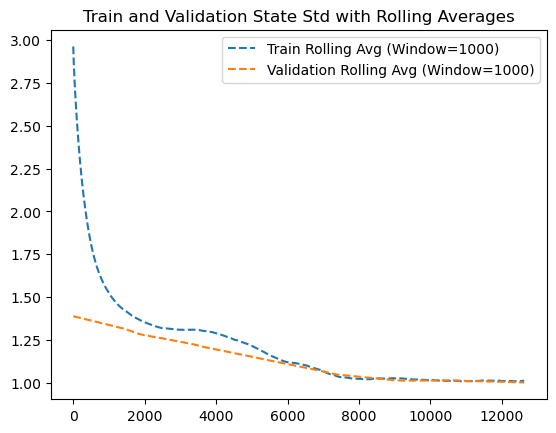

In [10]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Assuming `all_train_stds` and `all_val_stds` are your data lists or arrays
window_size = 1000

# Compute rolling averages
train_stds_avg = moving_average(all_train_stds, window_size)
val_stds_avg = moving_average(all_val_stds, window_size)

# Interpolate validation rolling average to match train's length
interp_val_stds_avg = np.interp(
    np.linspace(0, len(val_stds_avg) - 1, len(train_stds_avg)),  # New x-coordinates
    np.arange(len(val_stds_avg)),                               # Original x-coordinates
    val_stds_avg                                                # Data to interpolate
)

# Plot the results
# plt.plot(all_train_stds, label="Train State Std", alpha=0.5)
# plt.plot(all_val_stds, label="Validation State Std", alpha=0.5)
plt.plot(range(len(train_stds_avg)), train_stds_avg, label=f"Train Rolling Avg (Window={window_size})", linestyle='--')
plt.plot(range(len(train_stds_avg)), interp_val_stds_avg, label=f"Validation Rolling Avg (Window={window_size})", linestyle='--')

plt.title("Train and Validation State Std with Rolling Averages")
plt.legend()
plt.show()


In [11]:
#random state
state = train_states[0]
enc_state = model.state_encoder(state.unsqueeze(0))
enc_state

tensor([[-0.0216,  0.0015,  0.0056, -0.0265,  0.0035, -0.0049, -0.0285, -0.0266,
          0.0165, -0.0179,  0.0222, -0.0134, -0.0022,  0.0214, -0.0112,  0.0207,
         -0.0060, -0.0038,  0.0139,  0.0009, -0.0043,  0.0101,  0.0165, -0.0180,
         -0.0082,  0.0038, -0.0047,  0.0053, -0.0092, -0.0196,  0.0199, -0.0008,
         -0.0316,  0.0174, -0.0220,  0.0079, -0.0149, -0.0011,  0.0078, -0.0004,
          0.0161, -0.0149,  0.0285, -0.0188, -0.0071,  0.0039, -0.0084,  0.0137,
          0.0096,  0.0099,  0.0059, -0.0161,  0.0063,  0.0037, -0.0217,  0.0025,
         -0.0008, -0.0253, -0.0138, -0.0031,  0.0274,  0.0215, -0.0038,  0.0076]],
       grad_fn=<AddmmBackward0>)

In [ ]:
j

# Open Html file to view loss plots

In [10]:
#dataset of raw states, encoded into latent states
#See if can dist between latent states with each other | track while being trained (a curve)
#STD of all latent states (sum or avg then plot), mean
#To check if not collapsing 


# Init lunar lander env with wrapper to overrite default reward so hover in place is goal

In [12]:
class HoverLunarLander(gym.Wrapper):
    def __init__(self, env, target_location=(0.1, 0.25), epsilon=1e-3, 
                 penalty_landing=-50.0, penalty_crashing=-100.0, penalty_offscreen=-100.0):
        super(HoverLunarLander, self).__init__(env)
        self.target_x = target_location[0]
        self.target_y = target_location[1]
        self.epsilon = epsilon
        self.penalty_landing = penalty_landing
        self.penalty_crashing = penalty_crashing
        self.penalty_offscreen = penalty_offscreen

    def step(self, action):
        state, original_reward, terminated, truncated, info = self.env.step(action)
        x, y = state[0], state[1]
        distance = math.sqrt((x - self.target_x)**2 + (y - self.target_y)**2)
        inverse_distance_reward = 1.0 / (distance + self.epsilon)
        new_reward = inverse_distance_reward

        if terminated:
            if self.is_landed(state):
                new_reward += self.penalty_landing
                info['termination_cause'] = 'landed'
            else:
                new_reward += self.penalty_crashing
                info['termination_cause'] = 'crashed'
        elif truncated:
            new_reward += self.penalty_offscreen
            info['termination_cause'] = 'offscreen'
        
        return state, new_reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def is_landed(self, state):
        leg_contact = state[6] == 1 and state[7] == 1
        vertical_velocity = abs(state[3]) < 0.5
        horizontal_velocity = abs(state[2]) < 0.5
        angle = abs(state[4]) < 0.1
        return leg_contact and vertical_velocity and horizontal_velocity and angle
        
    def render(self, *args, **kwargs):
        return self.env.render(*args, **kwargs)


In [16]:
# #save model
# torch.save(model.state_dict(), "lunarlander_custom_reward_model_LQR_MODEL.pt")

# Play an episode with trained LQR, save replay as GIF

In [21]:
learned_A.max(), learned_B.max(), learned_Q.max(), learned_R.max()

(0.24303555, 0.11936776, 92.01232, 85.54709)

92.01232
1843980500.0
6.2191454e+25
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


C:\Users\mikef\AppData\Local\Temp\ipykernel_17784\4155839553.py:33: RuntimeWarning: overflow encountered in matmul
  P_new = Q + A.T @ P + P @ A - P @ B @ R_inv @ B.T @ P
C:\Users\mikef\AppData\Local\Temp\ipykernel_17784\4155839553.py:33: RuntimeWarning: invalid value encountered in matmul
  P_new = Q + A.T @ P + P @ A - P @ B @ R_inv @ B.T @ P


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
frames
52
Simulation saved as lunar_lander_lqr_new.gif
ACIONLIST 0


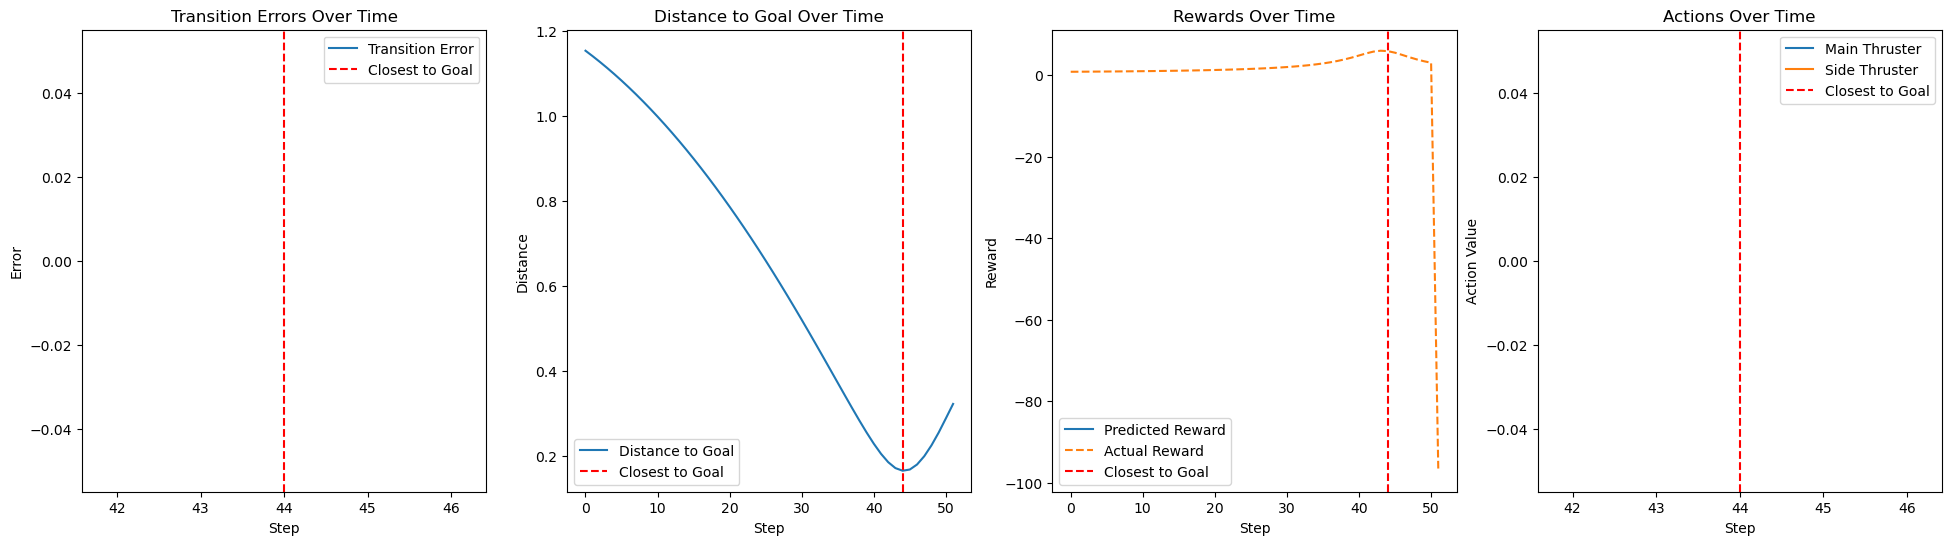

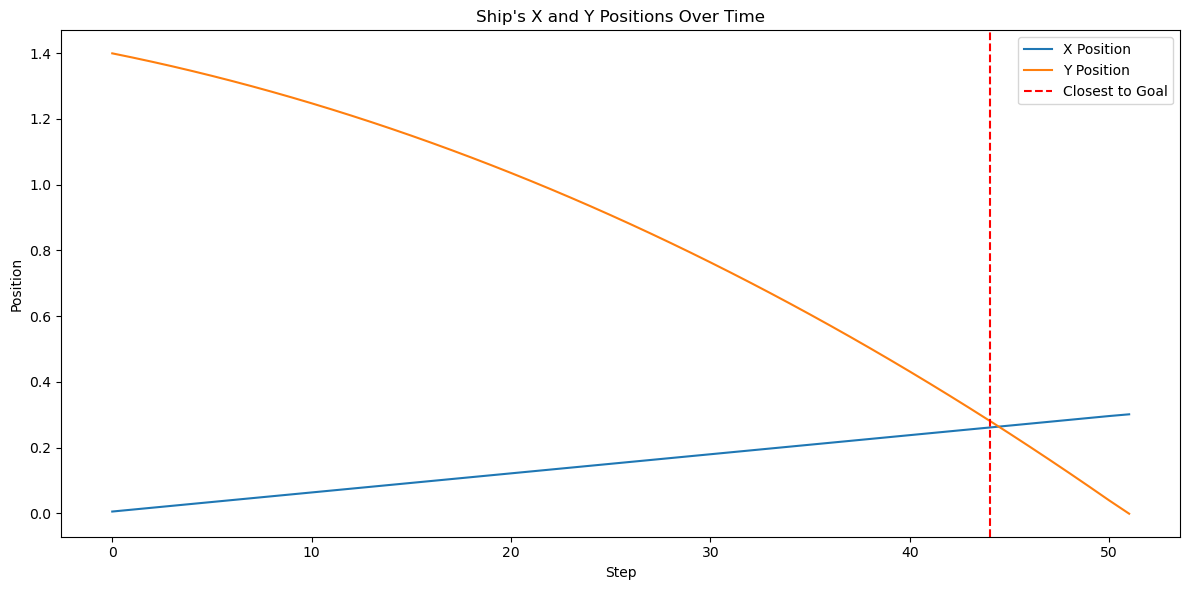

In [24]:
model.eval()
# Assuming 'model' is already defined and trained
def distance_to_goal(state, goal):
    x, y = state[0], state[1]
    goal_x, goal_y = goal
    return math.sqrt((x - goal_x)**2 + (y - goal_y)**2)
# Visualization metrics
transition_errors = []
distances_to_goal = []
action_list = []  # Actions applied
reward_list = []  # Actual rewards
predicted_rewards = []  # Predicted rewards
frames = []  # For GIF creation
positions = []  # To store (x, y) positions
# Initialize LunarLander environment
env = HoverLunarLander(gym.make("LunarLanderContinuous-v2",render_mode='rgb_array'), target_location=(0.1, 0.25))
observation, info = env.reset()
start_time = time.time()
with torch.no_grad():
    # # Extract learned matrices from the model
    A = model.A.detach().numpy()  # Get A as a numpy array
    #A_diag = np.diag(model.A_diag.detach().numpy())  # Create diagonal matrix from A_diag
    learned_A = A        #A + A_diag
    learned_B = model.B.detach().numpy()
    learned_Q = model.get_positive_semi_definite_matrix(model.Q_base).detach().numpy() 
    learned_R = model.get_positive_semi_definite_matrix(model.R_base).detach().numpy() 

    def approximate_riccati(A, B, Q, R, max_iter=1000, tol=1e-6):
        P = np.zeros_like(Q)  # Initialize P
        R_inv = np.linalg.inv(R)  # Precompute R inverse

        for _ in range(max_iter):
            P_new = Q + A.T @ P + P @ A - P @ B @ R_inv @ B.T @ P
            print(P_new.max())
            if np.linalg.norm(P_new - P) < tol:  # Check convergence
                print('Convergred')
                print(P_new.max())
                break
                
            P = P_new

        return P
    # # # # Solve Riccati equation to compute P
    #P = solve_continuous_are(learned_A, learned_B, learned_Q, learned_R)
    P = approximate_riccati(learned_A, learned_B, learned_Q, learned_R)
    # # Compute the gain matrix K
    K = np.linalg.inv(learned_R + learned_B.T @ P @ learned_B) @ (learned_B.T @ P @ learned_A)
    K_learned = torch.tensor(K, dtype=torch.float32)

    # Initialize state
    enc_state = model.state_encoder(torch.tensor(observation))
    og_state = observation
    counter =0
    while True:
        print(counter)
        counter += 1
        # Extract x and y positions
        x, y = og_state[0], og_state[1]
        positions.append((x, y))

        # Compute distance to goal
        dist_to_goal = distance_to_goal((x,y), (0.1, 0.25))
        distances_to_goal.append(dist_to_goal)

        # Compute action using LQR control law

        enc_action = (-K_learned @ enc_state.T).detach()  
        dec_action = model.action_decoder(enc_action.T)

        # Clip action to valid range
        # action_clipped = action.clamp(-1, 1)
        # action_np_clipped = action_clipped.detach().numpy().flatten() #shape is (16,)

        # Step environment
        observation, reward, terminated, truncated, info = env.step(dec_action.detach().numpy().flatten())
        #x, y = observation[0], observation[1]
        # print(x,y)
        # dist_to_goal = distance_to_goal((x,y), (0.1, 0.25))
        # print(dist_to_goal)
        reward_list.append(reward)
        #enc_action = model.action_encoder(torch.tensor(action_np_clipped, dtype=torch.float32).unsqueeze(0))
        # Predicted reward computation
        # print("enc_action")
        # print(enc_action.shape)
        # print("Learned R")
        # print(learned_R.shape)
        state_cost = (enc_state @ learned_Q @ enc_state.T)
        action_cost = (enc_action.T @ learned_R @ enc_action).item()
        predicted_reward = - (state_cost + action_cost)
        predicted_rewards.append(predicted_reward)

        # Capture frame
        frame = env.render()
        frames.append(frame)
        action_list.append(dec_action.detach().numpy().flatten())
        # Prepare for next step
        #next_state = np.concatenate((observation, np.array([dist_to_goal], dtype=np.float32)))
        enc_next_state = model.state_encoder(torch.tensor(observation))
      

        # Compute transition error
        next_state_pred = enc_state @ learned_A.T + enc_action.T @ model.B.T
        transition_error = torch.norm(torch.tensor(observation) - model.state_decoder(next_state_pred)).item()
        transition_errors.append(transition_error)

        # Update current state
        og_state = observation
        enc_state = enc_next_state



        # Check termination conditions
        if terminated or truncated or (time.time() - start_time > 10):
            break

# Close environment
env.close()
print("frames")
print(len(frames))
# Save GIF
gif_filename = "lunar_lander_lqr_new.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)
print(f"Simulation saved as {gif_filename}")

# Find the step where the agent is closest to the goal
closest_step = np.argmin(distances_to_goal)

# Visualization
plt.figure(figsize=(24, 6))

# Transition Errors
plt.subplot(1, 4, 1)
plt.plot(transition_errors, label="Transition Error")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Error")
plt.title("Transition Errors Over Time")
plt.legend()

# Distance to Goal
plt.subplot(1, 4, 2)
plt.plot(distances_to_goal, label="Distance to Goal")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Distance")
plt.title("Distance to Goal Over Time")
plt.legend()

# Rewards
plt.subplot(1, 4, 3)
plt.plot(predicted_rewards, label="Predicted Reward")
plt.plot(reward_list, label="Actual Reward", linestyle="--")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Rewards Over Time")
plt.legend()

# Actions
plt.subplot(1, 4, 4)
print("ACIONLIST 0")
actions_np = np.array(action_list)
plt.plot(actions_np[:, 0], label="Main Thruster")
plt.plot(actions_np[:, 1], label="Side Thruster")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Action Value")
plt.title("Actions Over Time")
plt.legend()

# Extract x and y positions
positions_np = np.array(positions)
x_positions = positions_np[:, 0]
y_positions = positions_np[:, 1]

# Plot x and y positions
plt.figure(figsize=(12, 6))
plt.plot(x_positions, label="X Position")
plt.plot(y_positions, label="Y Position")
plt.axvline(x=closest_step, color="red", linestyle="--", label="Closest to Goal")
plt.xlabel("Step")
plt.ylabel("Position")
plt.title("Ship's X and Y Positions Over Time")
plt.legend()

plt.tight_layout()
plt.show()

